In [458]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [459]:
file_types = ["cuda", "omp"]
def get_file_type(types, fname):
    for t in types:
        if t in fname:
            return t
    return None

def read_data(dir_name, file_types):
    if dir_name[-1] != "/":
        dir_name += "/"
    files = os.listdir(dir_name)

    result = {x:[] for x in file_types}
    for file in files:
        t = get_file_type(file_types, file)
        df = pd.read_csv(dir_name + file, sep="\s*\|\s*", engine='python')
        result[t].append(df)


    for t in file_types:
        result[t] = pd.concat(result[t])
        result[t].reset_index(drop=True, inplace=True)
        result[t].rename(columns={"Time (ms)": "time"}, inplace=True)

    return result

In [460]:
res = read_data("./bemchmark_results/", file_types)

In [461]:
df = res["cuda"].copy()
df.columns

Index(['N', 'bside', 'streams', 'kernel', 'memory', 'time', 'GFLOPS'], dtype='object')

In [462]:
ker_types = df.kernel.unique()
mem_types = df.memory.unique()
streams_arr = df.streams.unique()
N_arr = df.N.unique()
bside_arr = df.bside.unique()

ker2i = {ker: i for i, ker in enumerate(ker_types)}
mem2i = {mem: i for i, mem in enumerate(mem_types)}
stream2i = {stream: i for i, stream in enumerate(streams_arr)}
bside2i = {bside: i for i, bside in enumerate(bside_arr)}

print(ker_types)
print(mem_types)
print(streams_arr)
print(N_arr)
print(bside_arr)

['Simple' 'Shared' 'Shared_2' 'Shared_3' 'cuBLAS']
['Simple' 'Pinned' 'Unified']
[1 2 4 8]
[2000 4000 3000 5000]
[ 8 16 32]


In [463]:
bside_arr.astype(str)

array(['8', '16', '32'], dtype='<U21')

In [464]:
df = df[df.bside == 32].drop(columns="bside").reset_index(drop=True)

## Определения
### Типы памяти:
    Simple - обычные указатели
    Pinned - cuda pinned memory
    Unified - cuda managed memory
### Типы ядер:
    Simple - базовая имплементация перемножения матриц
    Shared - перемножение с подгрузкой в разделяемую память
    Shared_2 - оптимизация банков памяти за счёт транспонирования разделяемой памяти
    Shared_3 - оптимизация банков памяти за счёт сдвига разделяемой памяти

### Количество потоков
    streams - количество куда потоков, на которые разделялась задача (каждый поток погружает свою часть матрицы B  и считает свою часть матрицы C)

# CUDA

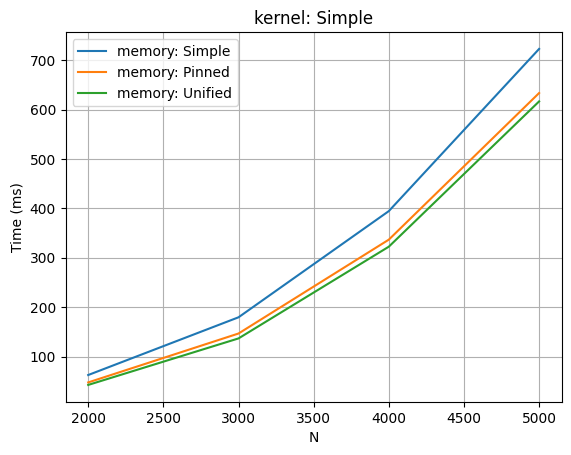

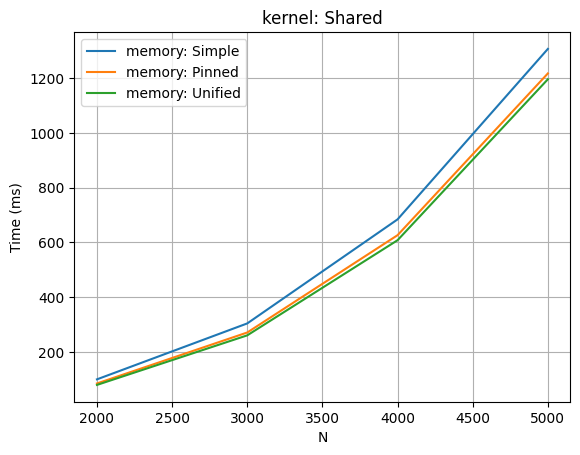

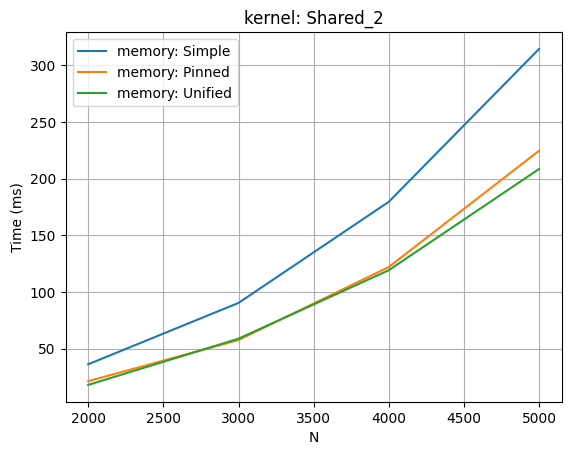

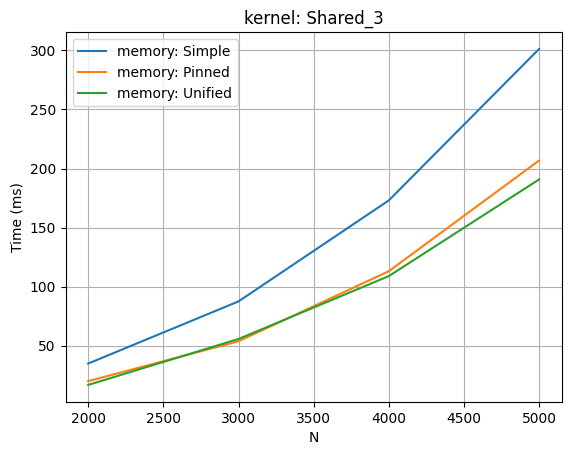

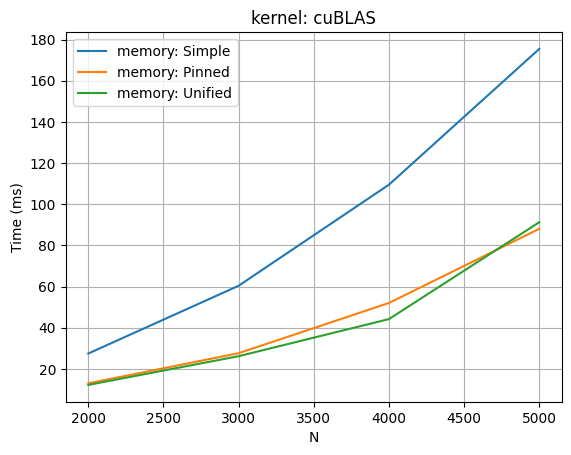

In [465]:
for kernel in ker_types:
    df_ker = df[(df.kernel == kernel) & (df.streams == 1)].copy()

    df_ker.sort_values(by=["memory", "N"], inplace=True)
    plt.figure()
    for mem in mem_types:
        df_mem = df_ker[df_ker.memory == mem]
        plt.plot(df_mem.N, df_mem.time, label=f"memory: {mem}")
    
    plt.legend(loc="best")
    plt.title(f'kernel: {kernel}')
    plt.xlabel("N")
    plt.ylabel("Time (ms)")
    plt.grid(True)
    plt.show()

Использование unified и pinned память значительно ускоряет передачу данных, оба метода показывают примерно одинаковые результаты.

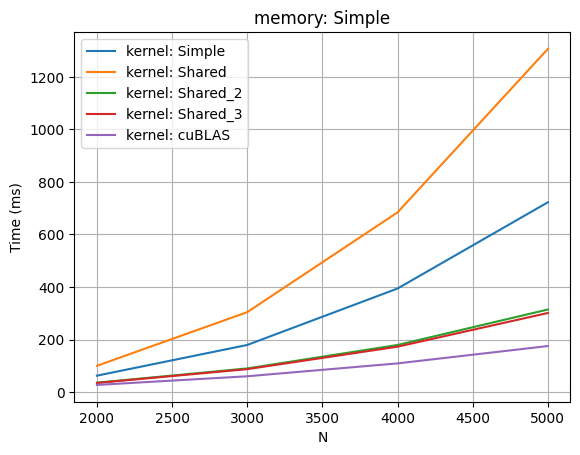

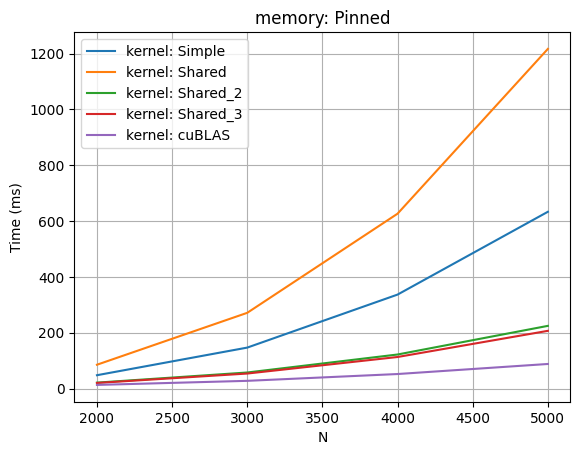

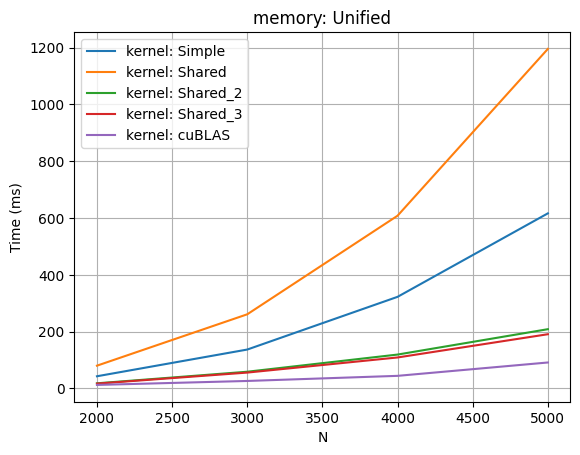

In [466]:
for mem in mem_types:
    df_mem = df[(df.memory == mem) & (df.streams == 1)].copy()

    df_mem.sort_values(by=["kernel", "N"], inplace=True)
    plt.figure()
    for kernel in ker_types:
        df_ker = df_mem[df_mem.kernel == kernel]
        plt.plot(df_ker.N, df_ker.time, label=f"kernel: {kernel}")
    
    plt.legend(loc="best")
    plt.title(f"memory: {mem}")
    plt.xlabel("N")
    plt.ylabel("Time (ms)")
    plt.grid(True)
    plt.show()

Shared_3 показывает лучший результат из реализованных функций. 
И Shared_2, и Shared_3 работают значительно быстрее чем Shared. В свою очередь Shared_3 эффективнее чем Shared_2, сдвиг память оказался эффективнее чем транспонирование. Транспонирование убирает конфликты возникающие из-за чтения матрицы а, но они всё ещё могут возникать из-за чтения матриц а и б разными потоками(где конфликт будет возникать гарантированно при каждом обращении). Когда сдвиг, хоть и не идеально, но борется со всеми вариантами появления конфликтов.

In [467]:
import itertools

In [468]:
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle

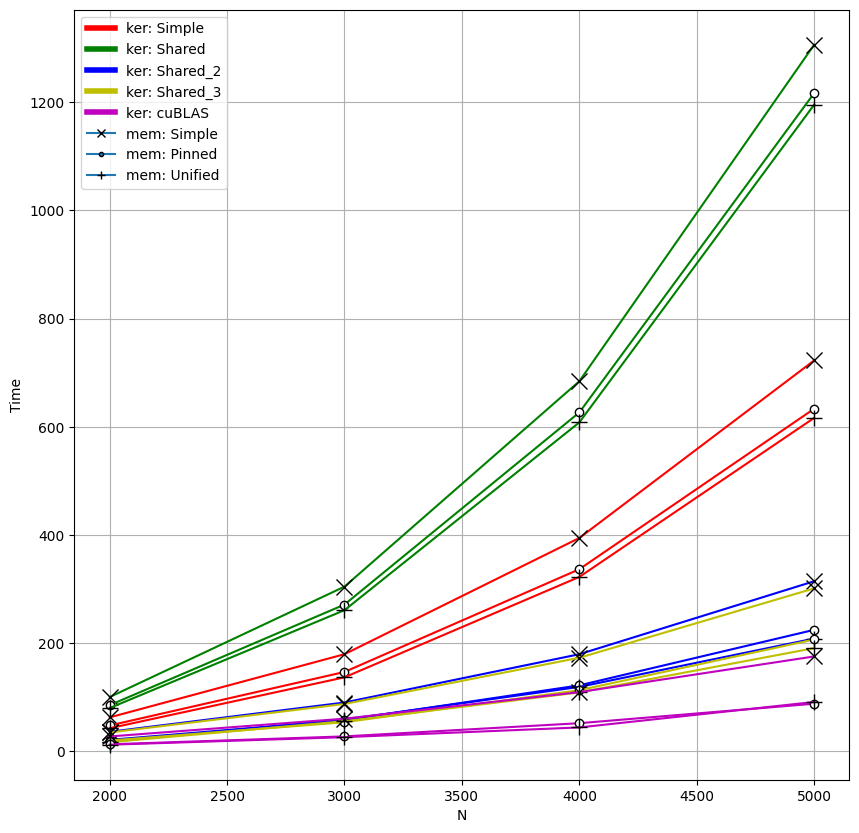

In [469]:
def foo():
    df_1 = df[df.streams == 1].copy()
    df_1.sort_values(by=["N"], inplace=True)
    plt.figure(figsize=(10, 10))
    colors = ["r", "g", "b", "y", "m", "c"]
    colors = colors[:len(ker_types)]
    markers = ["x", ".", "+", 7, 8, "s"]
    markers = markers[:len(mem_types)]

    custom_lines = [Line2D([0], [0], color=colors[x], lw=4) for x in range(len(colors))]
    custom_markers = [Line2D([0], [0], marker=x, markeredgecolor="black") for x in markers]

    for ker, mem in itertools.product(ker_types, mem_types):
        df_cur = df_1[(df_1.kernel == ker) & (df_1.memory == mem)]
        plt.plot(df_cur.N, df_cur.time, linestyle="-", marker=markers[mem2i[mem]], mec="black",
                 mfc="1", markersize=12, color=colors[ker2i[ker]], alpha=1, label=f"k:{ker}, m:{mem}")

    plt.xlabel("N")
    plt.ylabel("Time")
    plt.grid(True)
    plt.legend(custom_lines + custom_markers, ("ker: " + ker_types).tolist() + ("mem: " + mem_types).tolist())
    plt.show()

foo()

Не считая cuBLAS, при работе с одним потоком, показывает вариант \
ядро: Shared_3, память: Unified 

## Streams
Для удобства влияние количества потоков будет рассматриваться только для ядер: Shared_3 и cuBLAS

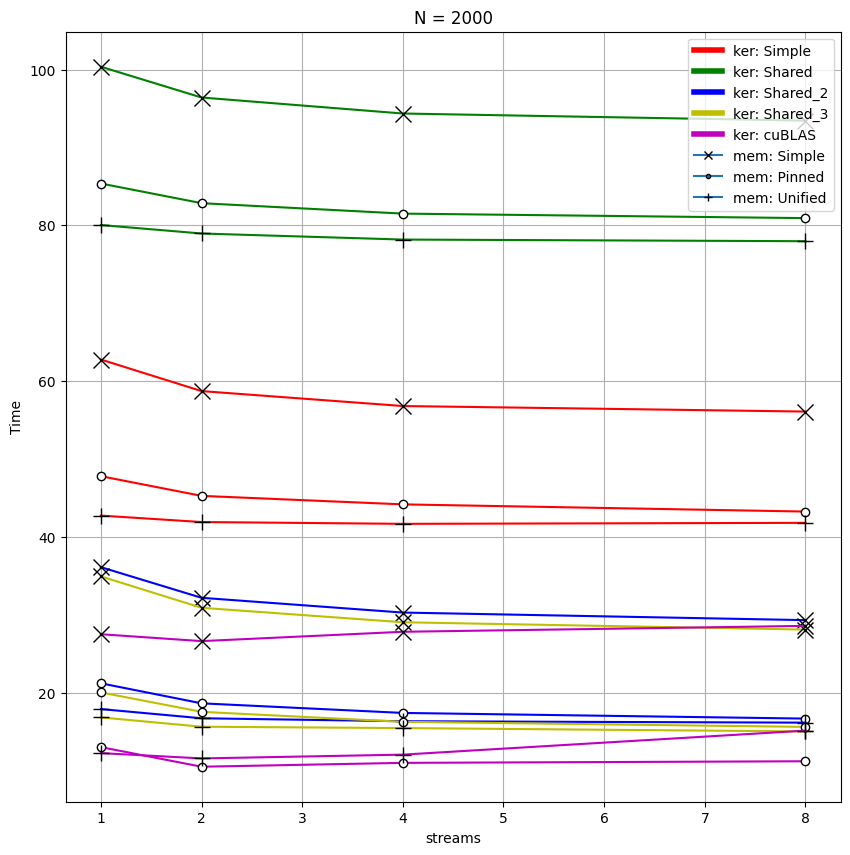

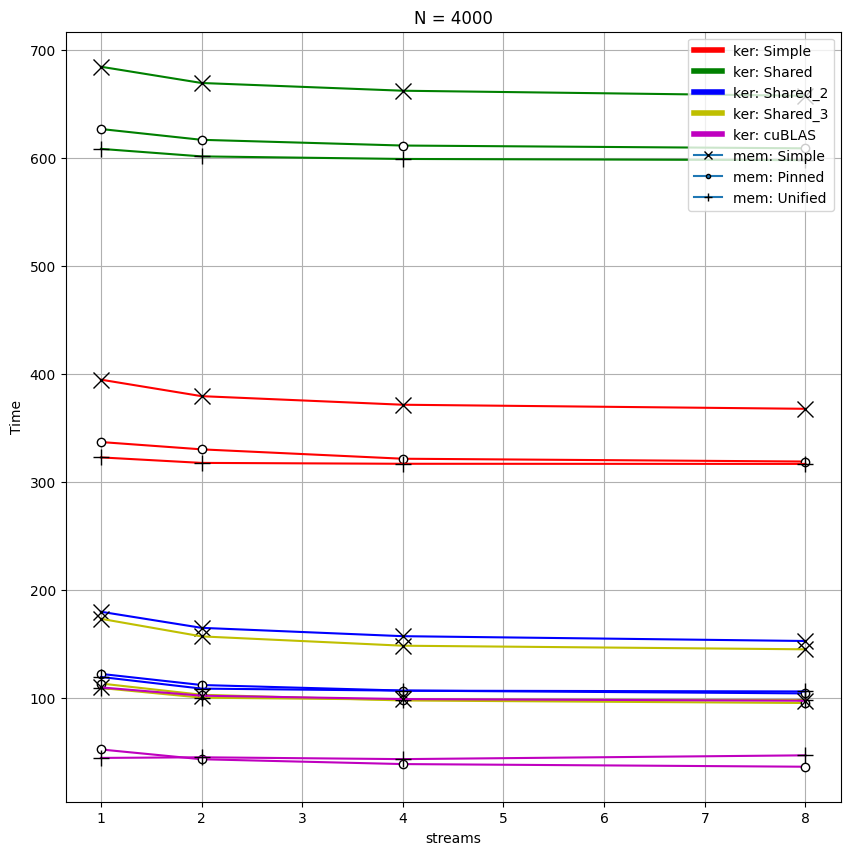

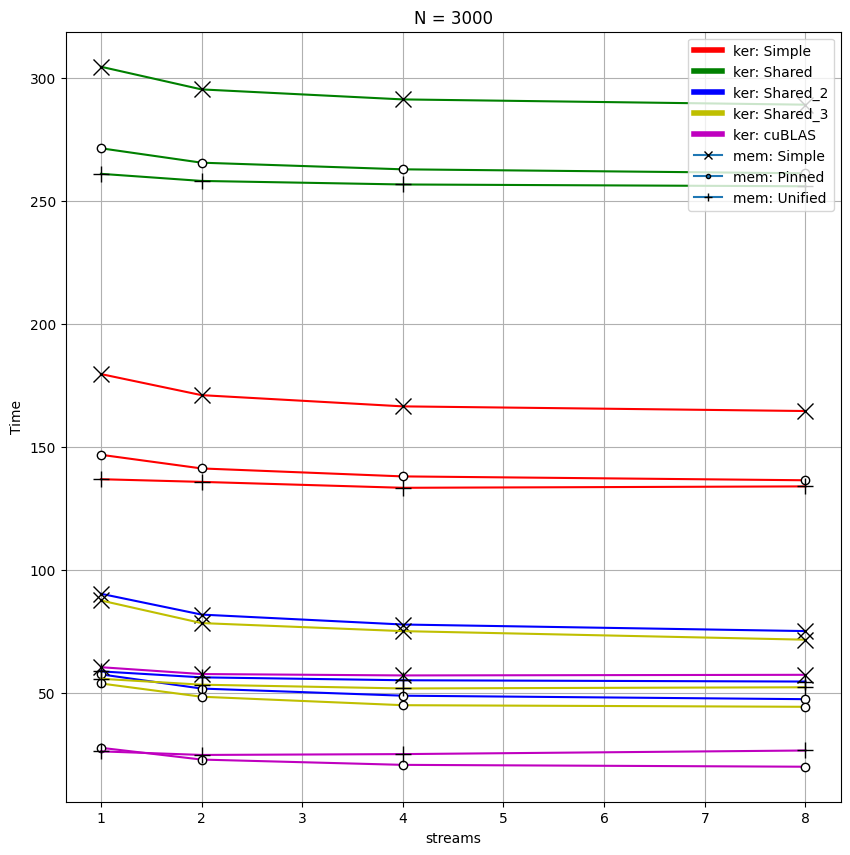

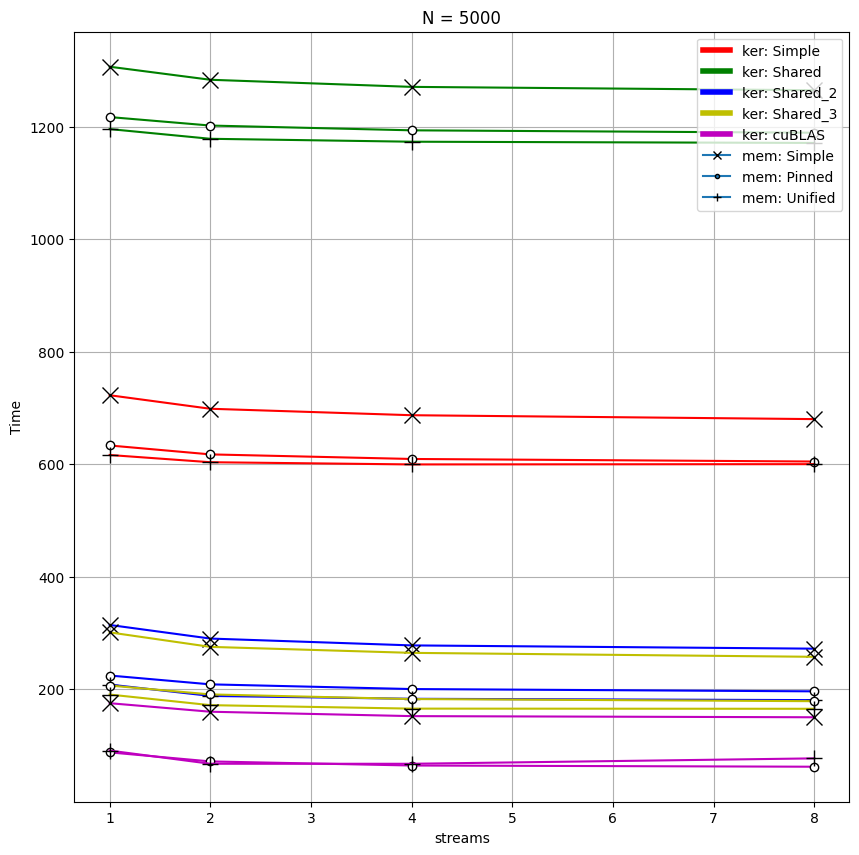

In [470]:
def foo():
    for n in N_arr:
        df_1 = df[df.N == n].copy()
        df_1.sort_values(by=["streams"], inplace=True)
        plt.figure(figsize=(10, 10))
        plt.title(f"N = {n}")
        colors = ["r", "g", "b", "y", "m", "c"]
        colors = colors[:len(ker_types)]
        markers = ["x", ".", "+", 7, 8, "s"]
        markers = markers[:len(mem_types)]

        custom_lines = [Line2D([0], [0], color=colors[x], lw=4) for x in range(len(colors))]
        custom_markers = [Line2D([0], [0], marker=x, markeredgecolor="black") for x in markers]

        for ker, mem in itertools.product(ker_types, mem_types):
            df_cur = df_1[(df_1.kernel == ker) & (df_1.memory == mem)]
            plt.plot(df_cur.streams, df_cur.time, linestyle="-", marker=markers[mem2i[mem]], mec="black",
                    mfc="1", markersize=12, color=colors[ker2i[ker]], alpha=1, label=f"k:{ker}, m:{mem}")

        plt.xlabel("streams")
        plt.ylabel("Time")
        plt.grid(True)
        plt.legend(custom_lines + custom_markers, ("ker: " + ker_types).tolist() + ("mem: " + mem_types).tolist())
        plt.show()

foo()

Увеличение количества потоков даёт прирост в скорости, для большинства алгоритмов 2-х потоков достаточно, и следующее увеличение их числа не даёт большой разницы. Для матриц с большим размером, большее количество потоков 

## Block Size

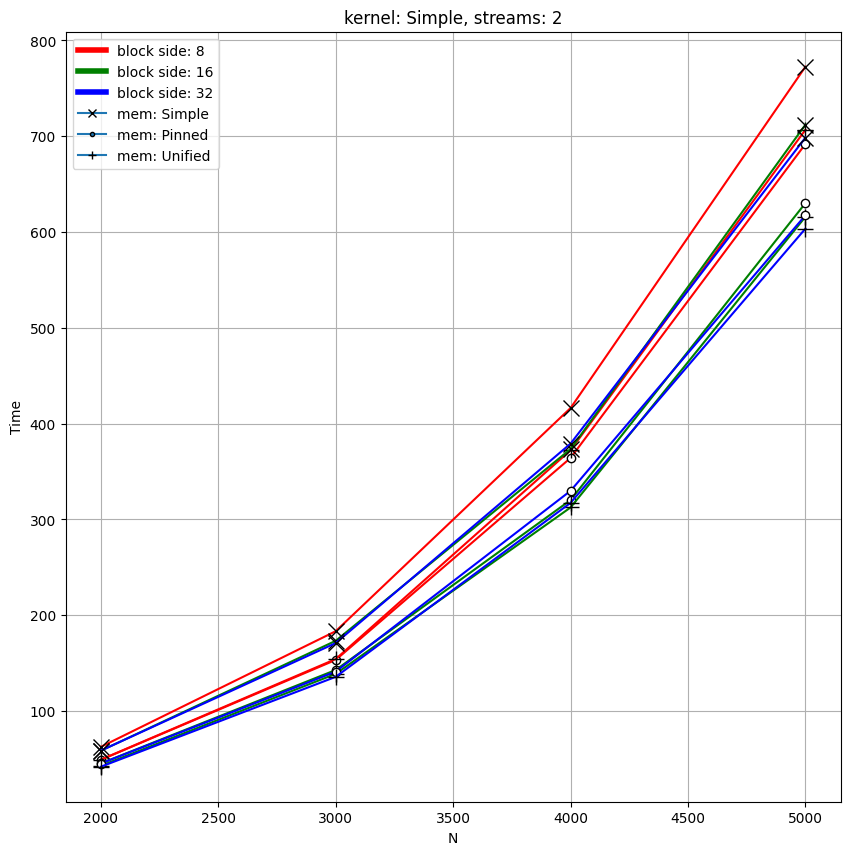

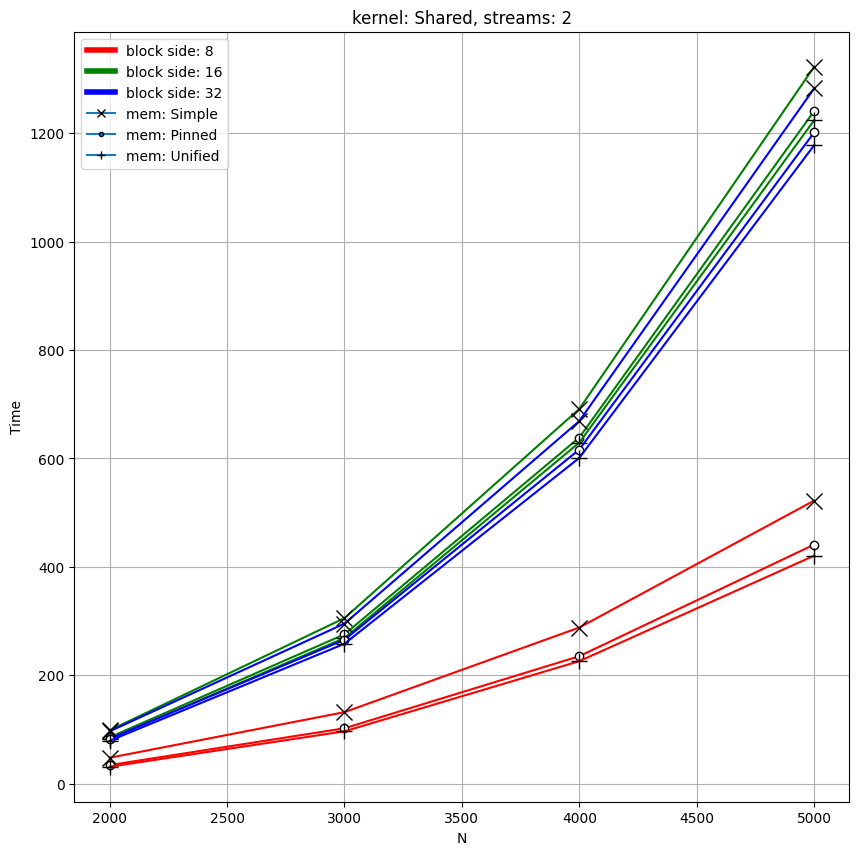

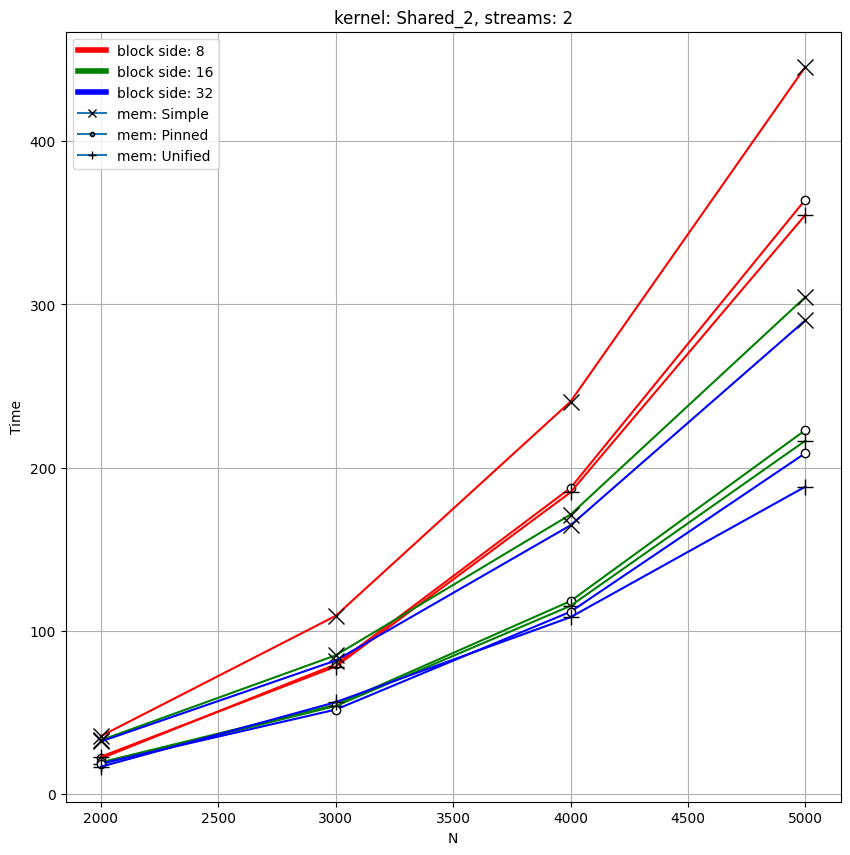

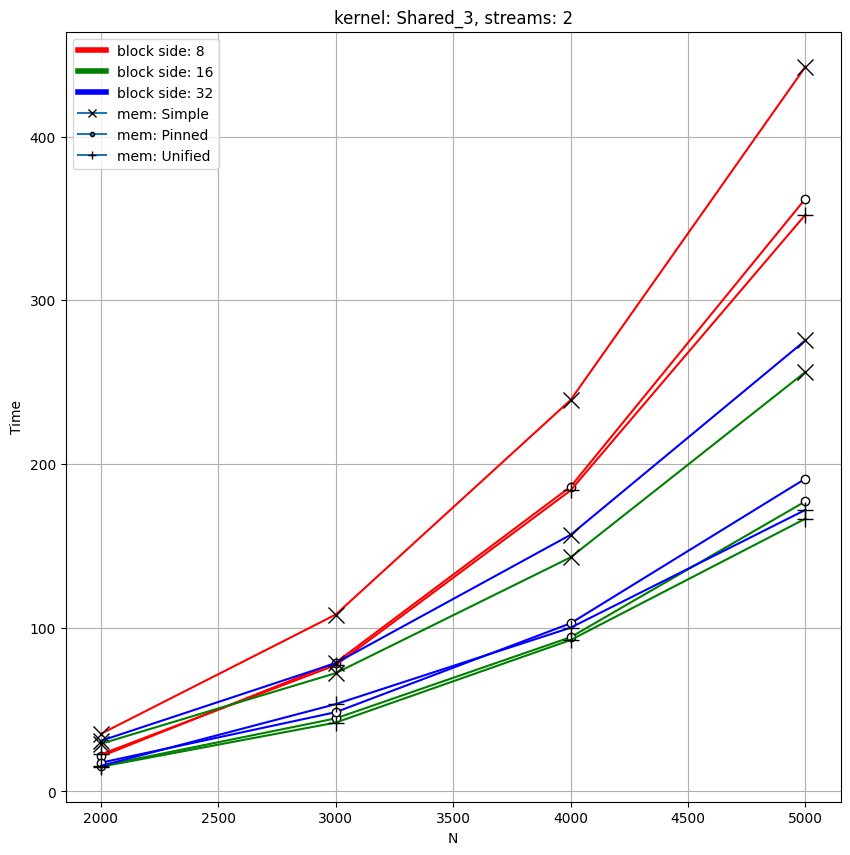

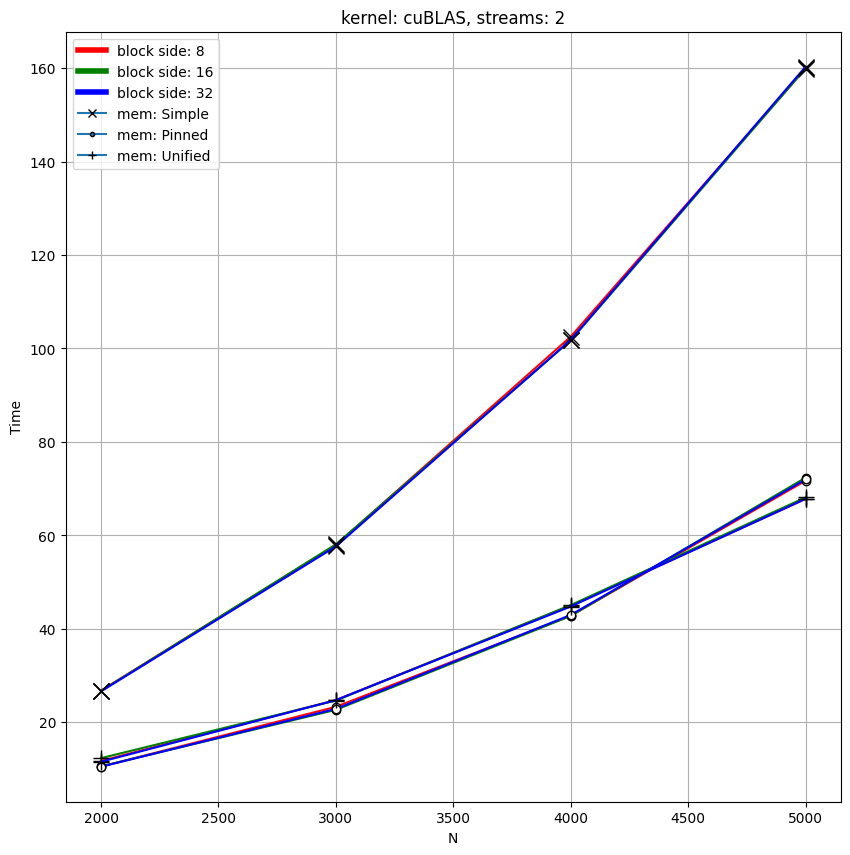

In [471]:
def foo():
    for ker in ker_types:
        df = res["cuda"]
        df_1 = df[(df.streams == 2) & (df.kernel == ker)].copy()
        df_1.sort_values(by=["N"], inplace=True)
        plt.figure(figsize=(10, 10))
        plt.title(f"kernel: {ker}, streams: 2")
        plt.xlabel("N")
        plt.ylabel("Time")
        colors = ["r", "g", "b", "y", "m", "c"]
        colors = colors[:len(bside_arr)]
        markers = ["x", ".", "+", 7, 8, "s"]
        markers = markers[:len(mem_types)]

        custom_lines = [Line2D([0], [0], color=colors[x], lw=4) for x in range(len(colors))]
        custom_markers = [Line2D([0], [0], marker=x, markeredgecolor="black") for x in markers]

        for bside, mem in itertools.product(bside_arr, mem_types):
            df_cur = df_1[(df_1.bside == bside) & (df_1.memory == mem)]
            plt.plot(df_cur.N, df_cur.time, linestyle="-", marker=markers[mem2i[mem]], mec="black",
                    mfc="1", markersize=12, color=colors[bside2i[bside]], alpha=1, label=f"k:{bside}, m:{mem}")

        plt.grid(True)
        plt.legend(custom_lines + custom_markers, ["block side: " + str(x) for x in bside_arr] + ("mem: " + mem_types).tolist())
        plt.show()

foo()

Для большинаства алгоритмов оптимальный размер блока 16x16. Неоптимизирванная разделяемя память работает быстрее при размере 8х8, так как тогда возникает меньше конфликтов банков.

# Лучший вариант

In [472]:
# best performing combination for each matrix size
df = res["cuda"]
df.iloc[df.groupby(by="N").idxmin().time]

,N,bside,streams,kernel,memory,time,GFLOPS
88,2000,32,2,cuBLAS,Pinned,10.503910,1523.242288
535,3000,16,8,cuBLAS,Pinned,19.953917,2706.235634
358,4000,32,8,cuBLAS,Pinned,36.054031,3550.227121
718,5000,32,8,cuBLAS,Pinned,62.559517,3996.194542


In [473]:
# best performing combination for each matrix size without cuBLAS
df.iloc[df[df.kernel != "cuBLAS"].groupby(by="N").idxmin().time]

,N,bside,streams,kernel,memory,time,GFLOPS
166,2000,16,8,Shared_3,Pinned,13.562464,1179.726655
526,3000,16,8,Shared_3,Pinned,39.500305,1367.078046
346,4000,16,8,Shared_3,Pinned,87.283165,1466.491276
706,5000,16,8,Shared_3,Pinned,164.777557,1517.196905


Для большей эффективности можно использовать блоки размером 16 на 16, и хранить

# OMP

In [474]:
df_omp = res["omp"]

In [475]:
df_omp

,N,time,GFLOPS
0,4000,6230.738616,20.54
1,3000,3683.607221,14.66
2,2000,1630.984592,9.81
3,5000,12894.980597,19.39


In [476]:
df_omp.sort_values(by="N", inplace=True)

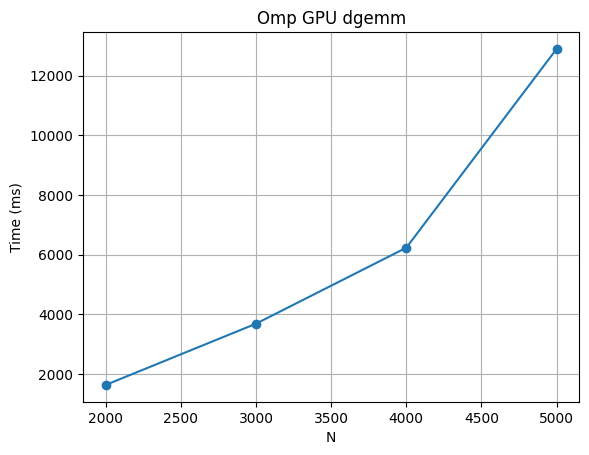

In [477]:
plt.plot(df_omp.N, df_omp.time, '-o')
plt.xlabel('N')
plt.title('Omp GPU dgemm')
plt.ylabel("Time (ms)")
plt.grid()
plt.show()


Базовая реализация на openmp работает в 20 раз медленней чем базовая реализация на cuda.